In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf, erfc, erfcx
from scipy.optimize import fixed_point
%matplotlib inline

from tqdm.notebook import tqdm

omega = 1
rho = 0.05
tau = 0.5
beta = 0.27

In [461]:
# This is the case for low SNR values ex: omega=0.15
def uninformative_P(xs):
    Z = beta / np.square(tau)
    return Z * np.exp(-2*Z * np.abs(xs))

def g(Q):
    return 0.5*np.square(tau)*(1+omega*np.square(Q))

def h(Q, R):
    return 0.5*(tau*omega*np.square(Q) - R + g(Q))

def f(x):
    # Normally erf has 2/sqrt(pi), but we have 2/np.pi
    return erfcx(x) / np.sqrt(np.pi)

def z(Q, R, xi, sgn):
    y = g(Q)*h(Q, R)
    y = 0.5*np.power(np.abs(y+1e-8), -0.5) * (beta + sgn*tau*omega*xi*Q)
    
    return y

def fixed_p_Q(Q, R):
    xi = 1 / np.sqrt(rho)
    y = np.sqrt(np.abs(g(Q)/(h(Q,R) + 1e-8)))
        
    z_p_sp = z(Q, R, xi, +1)
    z_n_sp = z(Q, R, xi, -1)
                
    y_Q = y * rho * xi * ((z_p_sp*f(z_p_sp) - z_n_sp*f(z_n_sp)) / (f(z_p_sp) + f(z_n_sp)))

    return y_Q

def fixed_p_R(Q, R):
    xi = 1 / np.sqrt(rho)
    y = np.sqrt(np.abs(g(Q)/(h(Q,R)+1e-8)))
        
    z_p_sp = z(Q, R, xi, +1)
    z_n_sp = z(Q, R, xi, -1)
    z_p_zr = z(Q, R, 0, +1)
    z_n_zr = z(Q, R, 0, -1)
        
    exp_val_zr = (1 - rho) * ((2/np.pi - z_p_zr*f(z_p_zr) - z_n_zr*f(z_n_zr)) / (f(z_p_zr) + f(z_n_zr) + 1e-8))
    exp_val_sp = rho * ((2/np.pi - z_p_sp*f(z_p_sp) - z_n_sp*f(z_n_sp)) / (f(z_p_sp) + f(z_n_sp) + 1e-8))
    y_R = beta * y * (exp_val_zr + exp_val_sp)
        
    return y_R

def fixed_p(x):
    return np.array([fixed_p_Q(x[0], x[1]), fixed_p_R(x[0], x[1])])

def Phi(x):
    return beta * np.abs(x)

def P(xs, xi, Q, R):
    y = h(Q, R) * np.square(xs) + Phi(xs) - tau*omega*Q*xi*xs
    y /= g(Q)
    return np.exp(-y) / (np.sum(np.exp(-y))*p)

In [475]:
def obj(x):
    q = fixed_p_Q(x[:3], x[3:])
    r = fixed_p_R(x[:3], x[3:])
    return np.array([q[0]-x[0], q[1]-x[1], q[2]-x[2], r[0]-x[3], r[1]-x[4], r[2]-x[5]])

def fix_p(x):
    q = fixed_p_Q(x[:2], x[2:])
    r = fixed_p_R(x[:2], x[2:])
    return np.sqrt(np.abs(np.array([q[0], q[1], r[0], r[1]])))

def solve():
    res = fsolve(obj, np.array([[0, 0.8], [0.125, 0.15]]))
    return (res[1], res[-1])

In [481]:
omega = 0.21
beta = 0.27
fsolve(obj, np.array([[0, 0.5, 0.8], [0.2, 0.17, 0.15]]), xtol=1e-3)

array([-7.59890033e-37,  4.57403140e-01,  4.59043083e-01,  1.25172123e-01,
        1.52194314e-01,  1.52295752e-01])

In [484]:
from scipy.optimize import fsolve

omegas = np.linspace(0, 1, 100)
Q_oist_th = []
beta = 0.27

for o in tqdm(omegas):
    omega = o
    q = fsolve(obj, np.array([[0, 0.5, 0.8], [0.2, 0.17, 0.15]]))[2]
    Q_oist_th.append(q)

/Users/cem/Documents/Migraine/denoise/venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/cem/Documents/Migraine/denoise/venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [473]:
from scipy.optimize import fsolve

omegas = np.linspace(0, 1, 100)
Q_oja_th = []
beta = 0

for o in tqdm(omegas):
    omega = o
    q = fsolve(obj, np.array([[0, 0.8], [0.125, 0.15]]))[1]
    Q_oja_th.append(q)

In [480]:
oist_mc_omega

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

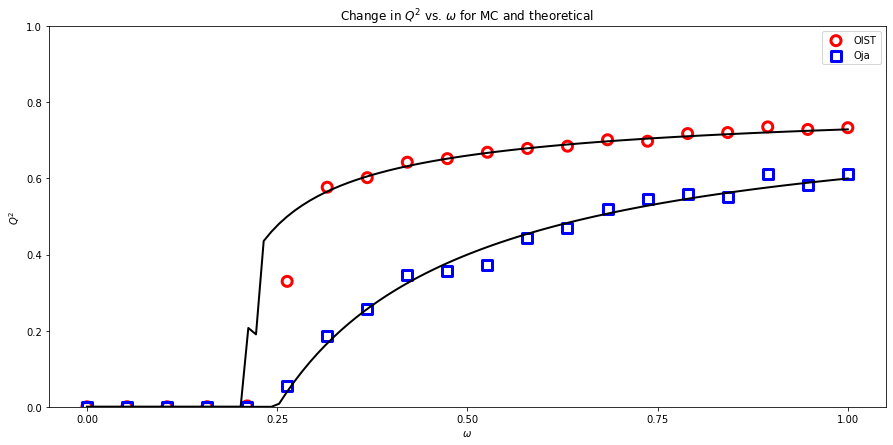

In [485]:
from scipy.signal import medfilt

Q_oist_mc = np.loadtxt('../data/omega_oist')
Q_oja_mc = np.loadtxt('../data/omega_oja')

oist_mc_omega = np.linspace(0, 1, 20)

fig, ax = plt.subplots(figsize=(15, 7))

plt.plot(omegas,np.square(Q_oist_th), c='black', lw=2)
plt.plot(omegas, np.square(Q_oja_th), c='black', lw=2)
plt.scatter(oist_mc_omega, np.square(Q_oist_mc), s=100, facecolors='none', edgecolors='r', linewidth=3, label='OIST')
plt.scatter(oist_mc_omega, np.square(Q_oja_mc), s=100, facecolors='none', edgecolors='b', marker='s', linewidth=3, label='Oja')

plt.ylim((0, 1))
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.ylabel('$Q^2$')
plt.xlabel('$\omega$');
plt.title("Change in $Q^2$ vs. $\omega$ for MC and theoretical")
plt.legend();

/Users/cem/Documents/Migraine/denoise/venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


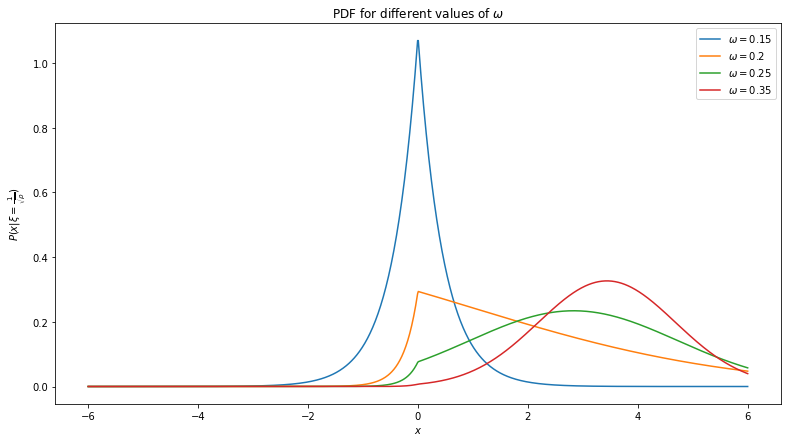

In [295]:
beta = 0.27
plt.figure(figsize=(13, 7))
for o in [0.15, 0.2, 0.25, 0.35]:
    omega = o
    q, r = solve()
    xs = np.linspace(-6, 6, 1000)

    pdf = P(xs, 1/np.sqrt(rho), q, r)
    
    plt.plot(xs, pdf, label=f"$\omega = {o}$")

plt.xlabel("$x$")
plt.ylabel(r"$P(x | \xi=\frac{1}{\sqrt{\rho}})$")
plt.title("PDF for different values of $\omega$")
plt.legend()